In [1]:
%pip install ultralytics opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pathlib import Path

import torch
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.6.0+cu124
CUDA available: True


In [3]:
# Root directory of your dataset
DATA_ROOT = Path("./Football Players.v15i.yolov11")  # <-- change this

train_images = DATA_ROOT / "train" / "images" 
val_images   = DATA_ROOT / "valid" / "images" 
train_labels = DATA_ROOT / "train" / "labels" 
val_labels   = DATA_ROOT / "valid" / "labels" 

print("Train images:", train_images)
print("Val images:", val_images)

print("Number of train images:", len(list(train_images.glob("*.jpg"))) + len(list(train_images.glob("*.png"))))
print("Number of val images:", len(list(val_images.glob("*.jpg"))) + len(list(val_images.glob("*.png"))))


Train images: Football Players.v15i.yolov11\train\images
Val images: Football Players.v15i.yolov11\valid\images
Number of train images: 774
Number of val images: 228


In [10]:
# List your classes in the order matching your YOLO labels
# Example only; replace with your real positions
class_names = [
    "CENTER",    # 0
    "DB",    # 1
    "LB",    # 2
    "QB",    # 3
    "SKILL",    # 4
]

NUM_CLASSES = len(class_names)

data_yaml = f"""
path: {DATA_ROOT.as_posix()}

train: {train_images.as_posix()}
val: {val_images.as_posix()}

names:
"""

for i, name in enumerate(class_names):
    data_yaml += f"  {i}: {name}\n"

print(data_yaml)



path: Football Players.v15i.yolov11

train: Football Players.v15i.yolov11/train/images
val: Football Players.v15i.yolov11/valid/images

names:
  0: CENTER
  1: DB
  2: LB
  3: QB
  4: SKILL



In [8]:
from pathlib import Path
import numpy as np

LABEL_DIR = Path(train_labels)  # <-- change this

class_ids = []

for txt in LABEL_DIR.glob("*.txt"):
    lines = txt.read_text().strip().splitlines()
    for line in lines:
        parts = line.split()
        if len(parts) == 0:
            continue
        cls = int(parts[0])
        class_ids.append(cls)

unique_ids = sorted(set(class_ids))

print("Class IDs found in dataset:", unique_ids)
print("Count per class ID:")
for cid in unique_ids:
    print(f"  {cid}: {class_ids.count(cid)} occurrences")


Class IDs found in dataset: [0, 1, 2, 3, 4]
Count per class ID:
  0: 1389 occurrences
  1: 6061 occurrences
  2: 5296 occurrences
  3: 1249 occurrences
  4: 6638 occurrences


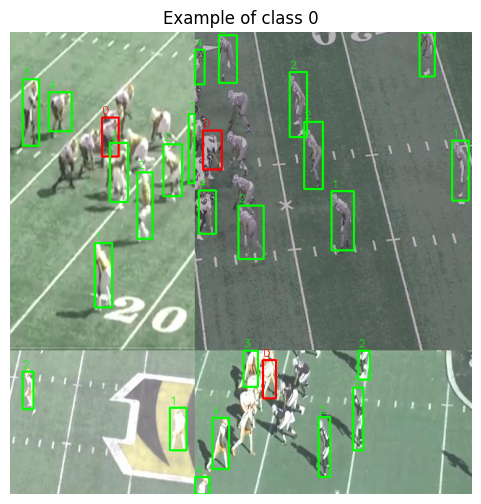

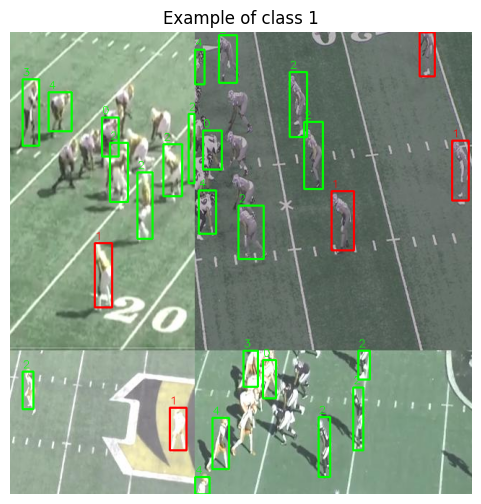

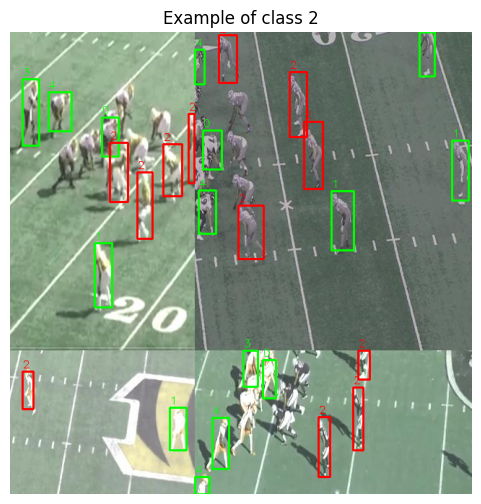

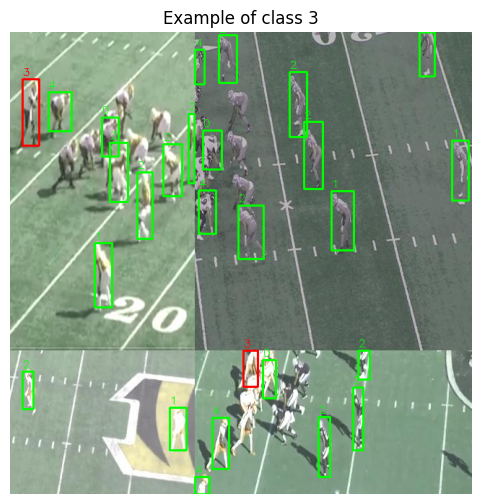

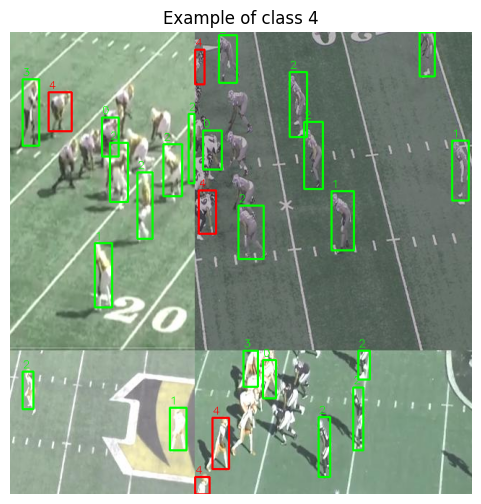

In [9]:
import cv2
import matplotlib.pyplot as plt

IMAGE_DIR = Path(train_images)  # <-- change this

def show_example_for_class(class_id):
    for txt in LABEL_DIR.glob("*.txt"):
        lines = txt.read_text().strip().splitlines()
        for line in lines:
            parts = line.split()
            if int(parts[0]) == class_id:
                img_path = IMAGE_DIR / (txt.stem + ".jpg")
                if not img_path.exists():
                    img_path = IMAGE_DIR / (txt.stem + ".png")
                if not img_path.exists():
                    continue

                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Draw all boxes from the file
                h, w = img.shape[:2]
                for line in lines:
                    cls, x, y, bw, bh = map(float, line.split())
                    x1 = int((x - bw/2) * w)
                    y1 = int((y - bh/2) * h)
                    x2 = int((x + bw/2) * w)
                    y2 = int((y + bh/2) * h)
                    color = (255, 0, 0) if int(cls) == class_id else (0, 255, 0)
                    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
                    cv2.putText(img, str(int(cls)), (x1, max(0,y1-5)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

                plt.figure(figsize=(6,6))
                plt.title(f"Example of class {class_id}")
                plt.imshow(img)
                plt.axis("off")
                return

    print(f"No image found for class {class_id}")

# Run visualization for each found class
for cid in unique_ids:
    show_example_for_class(cid)


In [18]:
# Choose a starting model
# Use "yolo11n.pt" if installed and available, else try "yolov8n.pt"
model_name = "yolo11n.pt"  # or "yolov8n.pt"

model = YOLO(model_name)

results = model.train(
    data=str("./Football Players.v15i.yolov11/data.yaml"),
    imgsz=640,
    epochs=50,        # increase to 100+ if you want more performance
    batch=16,
    name="football_positions",
    pretrained=True,
    device=0 if torch.cuda.is_available() else "cpu"
)


Ultralytics 8.3.229  Python-3.11.14 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./Football Players.v15i.yolov11/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=football_positions3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

In [20]:
metrics = model.val(
    data=str("./Football Players.v15i.yolov11/data.yaml"),
    imgsz=640,
    batch=16,
    device=0 if torch.cuda.is_available() else "cpu"
)

print(metrics)


Ultralytics 8.3.229  Python-3.11.14 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 748.6266.9 MB/s, size: 44.5 KB)
val: Scanning C:\Users\z\Documents\GitHub\NFL_Play_Outcome_Classifier\Football Players.v15i.yolov11\valid\labels.cache... 228 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 228/228 169.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 8.1it/s 1.8s<0.1s
                   all        228       3178      0.895      0.877      0.924       0.49
                     C        173        174      0.911       0.88      0.928      0.468
                    DB        228       1071      0.892      0.905      0.931      0.504
                    LB        227        562      0.821      0.874      0.903      0.506
                    QB        218        220

In [30]:
import random
from pathlib import Path

# val_images should already be defined, but if not:
# val_images = Path("path/to/your/val/images")

# Collect all possible image files
all_imgs = list(val_images.glob("*.jpg")) + list(val_images.glob("*.jpeg")) + list(val_images.glob("*.png"))

if len(all_imgs) == 0:
    sample_image = None
    print("No images found in:", val_images)
else:
    sample_image = random.choice(all_imgs)
    print("Random sample image:", sample_image)



Random sample image: Football Players.v15i.yolov11\valid\images\ud9HVbliaruyExnu_mp4-0_jpg.rf.2f61a5ab4ddd8534994f1288a2a98e03.jpg



image 1/1 C:\Users\z\Documents\GitHub\NFL_Play_Outcome_Classifier\Football Players.v15i.yolov11\valid\images\ud9HVbliaruyExnu_mp4-0_jpg.rf.2f61a5ab4ddd8534994f1288a2a98e03.jpg: 640x640 1 C, 5 DBs, 2 LBs, 1 QB, 5 SKILLs, 15.0ms
Speed: 2.2ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


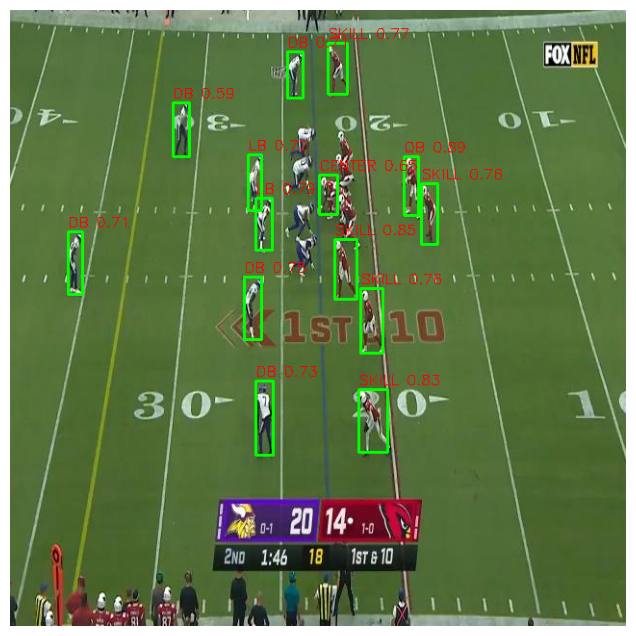

In [31]:
# Run prediction
pred_results = model.predict(
    source=str(sample_image),
    imgsz=640,
    conf=0.25,
    device=0 if torch.cuda.is_available() else "cpu",
    save=False
)

# Load image for display
img = cv2.imread(str(sample_image))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw detections
for r in pred_results:
    boxes = r.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        cls_id = int(box.cls[0].item())
        conf = float(box.conf[0].item())
        label = f"{class_names[cls_id]} {conf:.2f}"

        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.show()


In [32]:
# Export to a smaller format if you want to deploy
exported = model.export(format="onnx")  # or "engine", "torchscript", etc.
print("Exported model:", exported)


Ultralytics 8.3.229  Python-3.11.14 torch-2.6.0+cu124 CPU (12th Gen Intel Core i7-12700K)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'C:\Users\z\Documents\GitHub\NFL_Play_Outcome_Classifier\runs\detect\football_positions3\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ------- -------------------------------- 2.9/16.5 MB 23.8 MB/s eta 0:00:01
   --------------------- ------------------ 8.7/16.5 MB 25.5 MB/s eta 0:00:01
   ------------------------------------- -- 15.5/16.5 MB 27.8 MB/s eta 0:00:01
   ---------------------------------------- 16.5/16.5 MB 28.8 MB/s  0:00:00
   ----------------------------------